In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df1 = pd.read_excel("/Users/tina/Desktop/기계/R 3종 데이터/S&P 500/1번데이터.xlsx", index_col=0)

In [2]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data=[]
    labels=[]
    start_index=start_index+history_size
    if end_index is None:
        end_index=len(dataset)-target_size
    for i in range(start_index, end_index):
        indices=range(i-history_size,i)
        data.append(np.reshape(dataset[indices], (history_size,1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [3]:
uni_data=df1['종가']
uni_data.index=df1['날짜']
uni_data.head()

날짜
1980-01-01    107.9
1980-01-02    105.8
1980-01-03    105.2
1980-01-04    106.5
1980-01-07    106.8
Name: 종가, dtype: float64

array([<AxesSubplot:xlabel='날짜'>], dtype=object)

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)


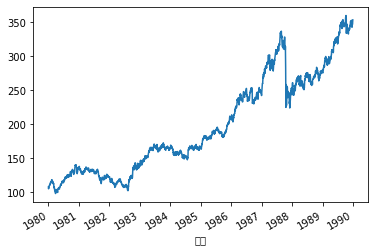

In [4]:
uni_data.plot(subplots=True)

In [5]:
uni_data=uni_data.values

In [6]:
import tensorflow as tf
TRAIN_SPLIT=1000
tf.random.set_seed(13)

/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [7]:
uni_train_mean=uni_data[:TRAIN_SPLIT].mean()
uni_train_std=uni_data[:TRAIN_SPLIT].std()
uni_data=(uni_data-uni_train_mean)/uni_train_std

In [8]:
univariate_past_history=20
univariate_future_target=0
x_train_uni, y_train_uni=univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni=univariate_data(uni_data, TRAIN_SPLIT,None, univariate_past_history, univariate_future_target)


In [9]:
print("single window of past history")
print(x_train_uni[0])
print('/n Target end price to predict')
print(y_train_uni[0])

single window of past history
[[-1.22260146]
 [-1.33258342]
 [-1.36400684]
 [-1.29592277]
 [-1.28021106]
 [-1.17022909]
 [-1.15975462]
 [-1.11785672]
 [-1.11785672]
 [-1.09167054]
 [-1.05500989]
 [-1.05500989]
 [-1.07595883]
 [-1.05500989]
 [-1.00263752]
 [-1.03406094]
 [-0.93455344]
 [-0.91884173]
 [-0.92407897]
 [-0.86123213]]
/n Target end price to predict
-0.8978927885428961


In [10]:
def create_time_steps(length):
    return list(range(-length,0))

In [11]:
def show_plot(plot_data, delta, title):
    labels=['History', 'True Future','Model Prediction']
    marker=['.-','rx','go']
    time_steps=create_time_steps(plot_data[0].shape[0])
    if delta:
        future=delta
    else:
        future=0
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps,plot_data[i].flatten(),marker[i], label=labels[i] )
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Timestep')
    return plt

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

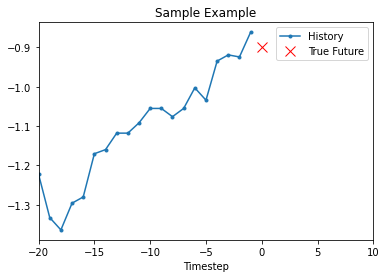

In [12]:
show_plot([x_train_uni[0], y_train_uni[0]],0,'Sample Example' )

In [13]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

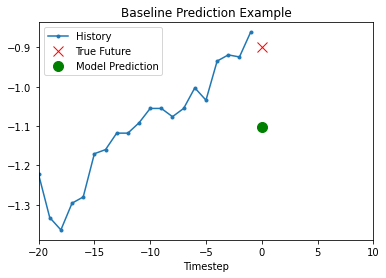

In [14]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])],0,'Baseline Prediction Example')

In [15]:
BATCH_SIZE=256
BUFFER_SIZE=10000
train_univariate=tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate=train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat
val_univariate=tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate=val_univariate.batch(BATCH_SIZE).repeat()

In [16]:
simple_lstm_model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [17]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [ ]:
EVALUATION_INTERVAL=200
EPOCHS=10
simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_univariate, validation_steps=50)


In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_univariate.shape[1], train_univariate.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

AttributeError: 'function' object has no attribute 'shape'

In [19]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])


NameError: name 'model' is not defined

Text(0, 0.5, 'price')

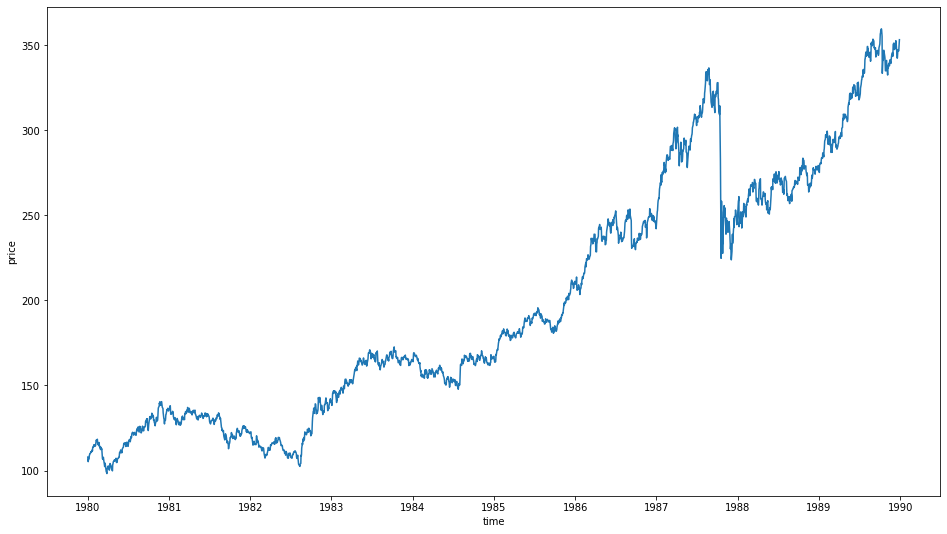

In [3]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df1['종가'], x=df1['날짜'])
plt.xlabel('time')
plt.ylabel('price')

In [9]:
def ts_train_test(all_data, time_steps, for_periods):
    ts_train=all_data[:'1988'].iloc[:,0:1].values
    ts_test=all_data['1989':].iloc[:,0:1].values
    ts_train_len=len(ts_train)
    ts_test_len=len(ts_test)
    X_train=[]
    y_train=[]
    y_train_stacked=[]
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train=np.array(X_train), np.array(y_train)
    X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    inputs=pd.concat((all_data['종가'][:1988],all_data['종가'][1989:]), axis=0).values
    inputs=inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs=inputs.reshape(-1,1)
    X_test=[]
    for i in range(time_steps, ts_test_len+ time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test=np.array(X_test)
    X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    return X_train, y_train, X_test

In [10]:
X_train, y_train, X_test=ts_train_test(all_data,5,2)
X_train_see=pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape1)))
y_train_see=pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis=1)
X_test_see=pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)
print("there are"+ str(X_train.shape[0]))
print("there are"+str(X_test.shape[0]))

TypeError: cannot do slice indexing on Int64Index with these indexers [1988] of type str

In [5]:
X_train=[]
y_train=[]
y_train_stacked=[]
for i in range(time_steps, ts_train_len-1):
    X_train.append(ts_train[i-time_steps:i,0])
    y_train.append(ts_train[i:i+for_periods,0])
X_train, y_train=np.array(X_train), np.array(y_train)

NameError: name 'time_steps' is not defined